### Variational Classifier  example 3  : random 2D circle --> binary class

INPUT: 2 real-valued vectors, works with shot-based simulator
Based on https://pennylane.ai/qml/demos/tutorial_variational_classifier/

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
qcstyle="black_white"

In [2]:
n_qubits=3
shots=5000
# pick one device
if 0:     # Initialize the FakeHanoi simulator
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.fake_provider  import FakeHanoi
    fake_hanoi_backend = FakeHanoi()
    aer_simulator = AerSimulator.from_backend(fake_hanoi_backend)
    dev = qml.device('qiskit.aer', wires=n_qubits, backend=aer_simulator, shots=shots)
if 0: # Set up a shot-based sim device.
    dev = qml.device('default.qubit', wires=n_qubits, shots=shots)
if 1:  # Set up the state vector sim  device
    dev = qml.device('default.qubit', wires=n_qubits)

### input data generated previously are imported

In [3]:
print('input 2D circle binary data and pre-process') 
XY = np.load("../notebooks/data/circ2d_bin.npy")
# Separate the data and labels
X = XY[:,:-1]
Y = XY[:,-1]
print('X sh:', X.shape, Y.shape)

print(f"First X sample (original)  : {X[0]}, shape:",X.shape)

print('Labels sample',Y[::10])
print(' Warning: data were not shuffled yet')

# Split data on train/test subsets
np.random.seed(0)
num_data = Y.shape[0]
num_train = int(0.7 * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

print('train labels sample',Y_train[:10])
print('train X sample',X_train[:3])
print('val labels sample',Y_val)

input 2D circle binary data and pre-process
X sh: (300, 2) (300,)
First X sample (original)  : [-0.63598068  0.41293217], shape: (300, 2)
Labels sample [ 1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.]
train labels sample [-1. -1. -1.  1.  1. -1. -1. -1.  1.  1.]
train X sample [[-0.72389289 -0.77640799]
 [-0.8875075  -0.66475994]
 [ 0.53171998  0.76290153]]
val labels sample [ 1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1.
  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.
  1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.
  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1. -1. -1.]


[Text(0.5, 1.0, 'Original data 2 classes')]

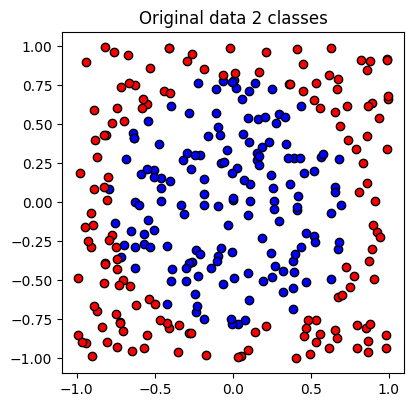

In [4]:
nrow,ncol=1,3
fig=plt.figure(facecolor='white', figsize=(15,4.5))

ax = plt.subplot(nrow,ncol,1) ; ax.set_aspect(1.)
ax.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
ax.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
ax.set(title="Original data 2 classes")

### Encoding
Input X is in range [-1,1], it will be mapped to theta=acos(X) and encoded as RY(tehta) onto 2 qubits

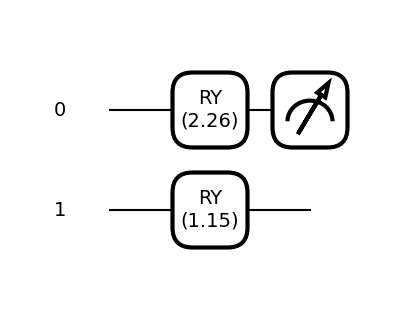

In [5]:
def state_preparation(x):
    a=np.arccos(x)
    qml.RY(a[0], wires=0)
    qml.RY(a[1], wires=1)

@qml.qnode(dev)
def test(angles):
    state_preparation(angles)
    return qml.expval(qml.PauliZ(0))

qml.draw_mpl(test, decimals=2, style=qcstyle)(X[0]); plt.show()
#print(qml.draw(test, decimals=2)(X[0]), '\n')

### Define QML layers, as   2-qubit variational layer

define the variational quantum circuit as this state preparation routine, followed by a repetition of the layer structure.

QML dims  qubits=3  EfficientSU2 ansatz, layers=2
weights sh: (2, 3, 3) 
 full circ:


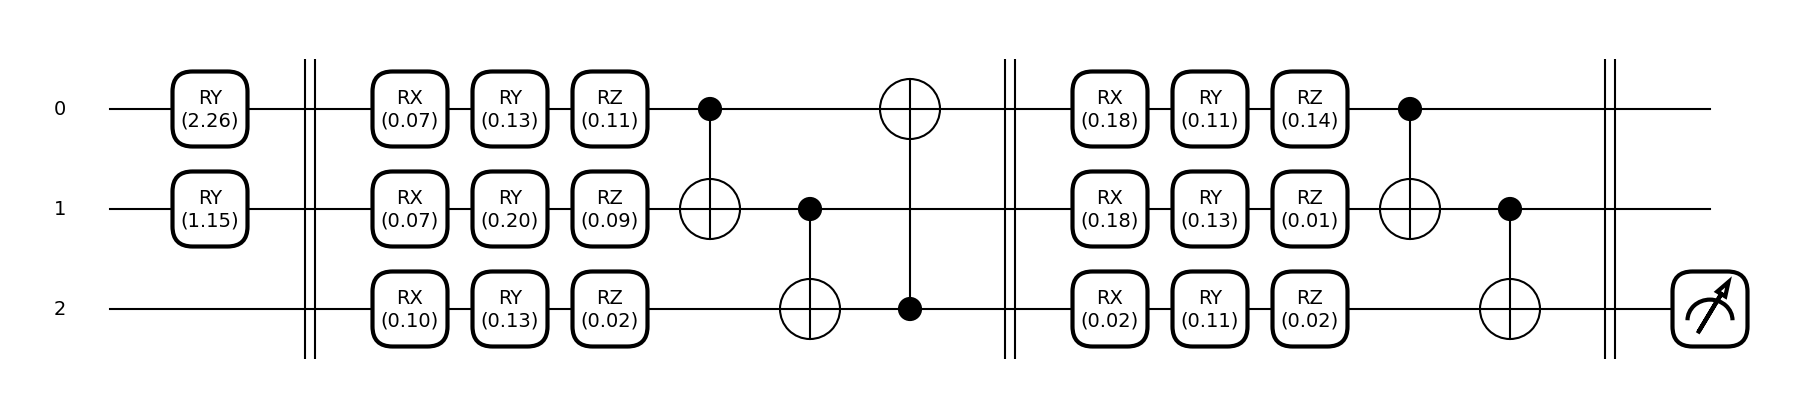

In [12]:
# Define the EfficientSU2 ansatz
def efficient_su2_ansatz(params):
    """
    EfficientSU2 ansatz for 3 qubits.
    Parameters should have a shape of (layers, n_qubits, 3),
    where layers is the number of ansatz layers,
    n_qubits is the number of qubits (3 in this case),
    and 3 represents the rotation angles for RX, RY, and RZ gates.
    """
    # Number of layers
    layers = params.shape[0]

    for layer in range(layers): # Apply rotational gates to each qubit
        qml.Barrier()
        for qubit in range(n_qubits):
            qml.RX(params[layer, qubit, 0], wires=qubit)
            qml.RY(params[layer, qubit, 1], wires=qubit)
            qml.RZ(params[layer, qubit, 2], wires=qubit)
        
        # Apply CNOTs for entanglement, forming a ring of qubits
        max_qubit=n_qubits
        if  layer==layers-1: max_qubit-=1
        for qubit in range(max_qubit):
            qml.CNOT(wires=[qubit, (qubit + 1) % n_qubits])
    qml.Barrier()

# Define a QNode that uses the ansatz
@qml.qnode(dev)
def circuit(params,x):
    state_preparation(x)  
    efficient_su2_ansatz(params)
    return qml.expval(qml.PauliZ(2))

#........ test full circuit 
# Example usage
layers = 2
num_u3_ang= 3  # const, relates to U3 parametrization
weights_init = 0.2 * np.random.random(size=(layers, n_qubits, num_u3_ang))

print('QML dims  qubits=%d  EfficientSU2 ansatz, layers=%d'%(n_qubits,layers))
print('weights sh:',weights_init.shape,'\n full circ:')

qml.draw_mpl(circuit, decimals=2, style=qcstyle)(weights_init,X[0]); plt.show()
#print(qml.draw(circuit, decimals=2)(weights_init,X[0]), '\n')

### remaining classical functionality required for ML training 

In [7]:
#  loss-function
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(weights,  X, Y):
    global function_calls
    function_calls += X.shape[0]
    # Transpose the batch of input data in order to match the expected dims
    pred = circuit(weights,  X.T) # circuit is vectorized
    return square_loss(Y, pred)
    
#  ACCURACY, for monitoring only
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [8]:
# Optimization   https://openqaoa.entropicalabs.com/optimizers/pennylane-optimizers/
# do HPO here
batch_size = 20
steps = 200
opt = NesterovMomentumOptimizer(stepsize=0.05, momentum=0.95)

In [9]:
print('\n train the variational classifier...')

weights = weights_init
function_calls = 0
best_acc=-1; best_weights=None; best_step=-1; best_fcnt=-1
for it in range(steps):
    # Update the weights by one optimizer step, use just one batch-size of data selected at random, so 1 step is NOT 1 epoch
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    
    weights = opt.step(lambda p: cost(p, X_batch, Y_batch), weights)
    # Compute predictions on train and validation set
    pred_val = np.sign(circuit(weights,  X_val.T))
    acc_val = accuracy(Y_val, pred_val)
    pred_train = np.sign(circuit(weights,  X_train.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, pred_train)
    # retain best *train* accuracy weights
    if best_acc< acc_train:
        best_acc=acc_train ; best_weights=weights
        best_step=it;  best_fcnt=function_calls
        print('  step=%d new best train_acc: %.3f, val:%.3f'%(it,best_acc,acc_val))

    if (it + 1) % 20 == 0 or it<5:
        _cost = cost(weights,  X_train,Y_train)
        print(
            f"Iter: {it + 1:4d} | train Cost: {_cost:0.3f} | "
            f"Acc train: {acc_train:0.3f} | Acc validation: {acc_val:0.3f}"
        )


 train the variational classifier...
  step=0 new best train_acc: 0.505, val:0.433
Iter:    1 | train Cost: 1.250 | Acc train: 0.505 | Acc validation: 0.433
  step=1 new best train_acc: 0.538, val:0.433
Iter:    2 | train Cost: 1.198 | Acc train: 0.538 | Acc validation: 0.433
  step=2 new best train_acc: 0.581, val:0.500
Iter:    3 | train Cost: 1.137 | Acc train: 0.581 | Acc validation: 0.500
  step=3 new best train_acc: 0.605, val:0.522
Iter:    4 | train Cost: 1.075 | Acc train: 0.605 | Acc validation: 0.522
  step=4 new best train_acc: 0.652, val:0.567
Iter:    5 | train Cost: 1.014 | Acc train: 0.652 | Acc validation: 0.567
  step=5 new best train_acc: 0.700, val:0.611
  step=14 new best train_acc: 0.752, val:0.733
  step=15 new best train_acc: 0.800, val:0.778
Iter:   20 | train Cost: 0.841 | Acc train: 0.781 | Acc validation: 0.789
Iter:   40 | train Cost: 0.812 | Acc train: 0.714 | Acc validation: 0.633
  step=44 new best train_acc: 0.810, val:0.733
  step=54 new best train_ac

In [10]:
#  make a predictions for val-data
weights= best_weights
pred_val = np.sign(circuit(weights,  X_val.T))
acc_val = accuracy(Y_val, pred_val)
print('\n INFER on val-data,   acc_val=%.3f'%acc_val)
print('\npred_val:%s'%(pred_val[:15]))
print('targets:',Y_val[:15])
res=pred_val - Y_val
l2=res**2
print('L2:',l2[:15])
loss = square_loss(Y_val, pred_val)
print('loss:',loss,'ndata:',pred_val.shape)
print("Total number of cost function calls:", function_calls)
print('qml setup:',dev,opt)
print('best-weight:',weights)


 INFER on val-data,   acc_val=0.911

pred_val:[ 1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.]
targets: [ 1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.]
L2: [0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0.]
loss: 0.35555555555555557 ndata: (90,)
Total number of cost function calls: 7150
qml setup: <default.qubit device (wires=3) at 0x7fb1ba6cb550> <pennylane.optimize.nesterov_momentum.NesterovMomentumOptimizer object at 0x7fb1b81a5a50>
best-weight: [[[ 0.25521643  0.09400646 -0.03642266]
  [ 1.22488011 -0.0597647   0.20920577]
  [ 0.72562235 -0.00483104 -0.01722924]]

 [[ 1.20416725 -1.36381317  0.0433794 ]
  [-0.05524293 -0.08872729  0.0041302 ]
  [ 0.68519535  0.06418307  0.07669278]]]


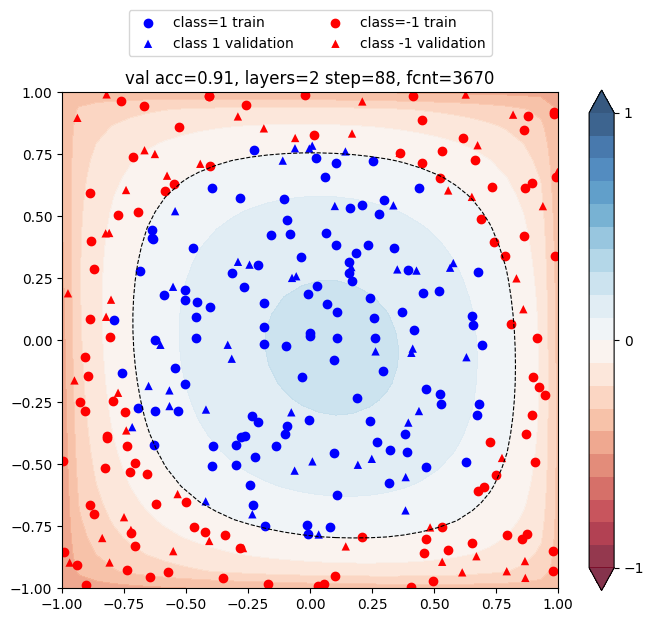

In [11]:
# We can plot the continuous output of the variational classifier for the first two dimensions of the Iris data set.
fig=plt.figure(facecolor='white', figsize=(8,6.5))
nrow,ncol=1,1
cm = plt.cm.RdBu
ax = plt.subplot(nrow,ncol,1) ; ax.set_aspect(1.)

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-1,1, 30), np.linspace(-1,1, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

features_grid = np.array([x for x in X_grid])  # angles are new features
predictions_grid = circuit(weights,  features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
ax.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    ax.scatter(plot_x, plot_y, c=color, marker="o", label="class=%d train"%label)
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    ax.scatter(plot_x, plot_y, c=color, ec='none', marker="^", label=f"class {label} validation")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2)
ax.set(title='val acc=%.2f, layers=%d step=%d, fcnt=%d'%(acc_val,layers,best_step,best_fcnt))
plt.show()